This notebook is part of the $\omega radlib$ documentation: http://wradlib.org/wradlib-docs.

Copyright (c) 2018, $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Example for georeferencing a radar dataset

In [1]:
import wradlib.georef as georef
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

/home/travis/miniconda/envs/wradlib/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**1st step:** Compute centroid coordinates and vertices of all radar bins in WGS84 (longitude and latitude).

In [2]:
# Define the polar coordinates and the site coordinates in lat/lon    
r = np.arange(1, 129) * 1000
az = np.linspace(0, 360, 361)[0:-1]

# Site coordinates for different DWD radar locations (you choose)
# LAT:  drs:  51.12527778 ; fbg: 47.87444444 ; tur: 48.58611111 ; # muc: 48.3372222
# LON:  drs:  13.76972222 ; fbg: 8.005 ; tur: 9.783888889 ; muc: 11.61277778
sitecoords = (9.7839, 48.5861)

We can now generate the polgon vertices of the radar bins - with **each vertex in lon/lat coordinates**.

In [3]:
proj_wgs84 = georef.epsg_to_osr(4326)
polygons = georef.spherical_to_polyvert(r, az, 0, sitecoords, 
                                        proj=proj_wgs84)
polygons = polygons[..., 0:2]

... or we can compute the corresponding centroids of all bins -  - with **each centroid in lon/lat coordinates**.

In [4]:
cent_coords = georef.spherical_to_centroids(r, az, 0, sitecoords,
                                            proj=proj_wgs84)
cent_lon = cent_coords[..., 0]
cent_lat = cent_coords[..., 1]

In order to understand how vertices and centroids correspond, we can plot them together.

(48.8361, 48.96877939304968)

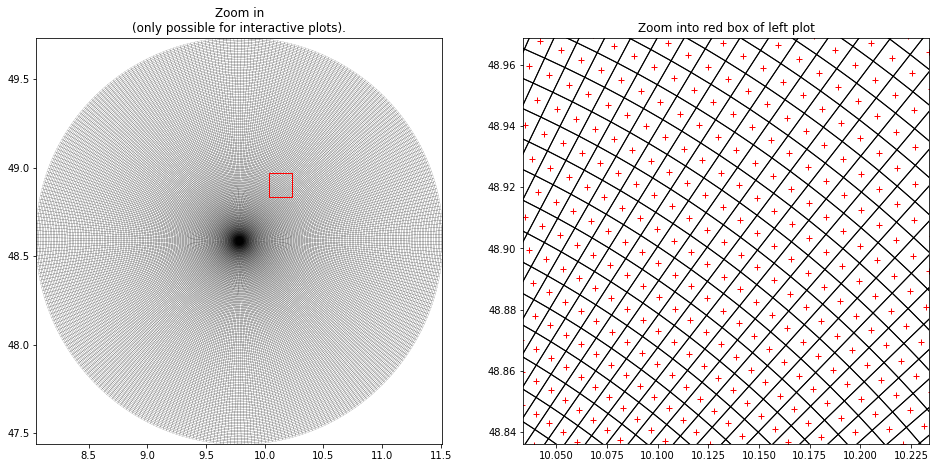

In [5]:
fig = pl.figure(figsize=(16, 16))
aspect = ( cent_lon.max()-cent_lon.min() ) / ( cent_lat.max()-cent_lat.min() )
ax = fig.add_subplot(121, aspect = aspect )
polycoll = mpl.collections.PolyCollection(polygons, closed=True,
                                          facecolors='None', linewidth=0.1)
ax.add_collection(polycoll, autolim=True)
#ax.plot(cent_lon, cent_lat, 'r+')
pl.title('Zoom in\n(only possible for interactive plots).')
ax.add_patch(Rectangle((sitecoords[0]+0.25, sitecoords[1]+0.25), 0.2, 0.2/aspect, edgecolor="red", facecolor="None", zorder=3))
pl.xlim(cent_lon.min(), cent_lon.max())
pl.ylim(cent_lat.min(), cent_lat.max())

ax = fig.add_subplot(122, aspect = aspect)
polycoll = mpl.collections.PolyCollection(polygons, closed=True,
                                          facecolors='None')
ax.add_collection(polycoll, autolim=True)
ax.plot(cent_lon, cent_lat, 'r+')
pl.title('Zoom into red box of left plot')
pl.xlim(sitecoords[0]+0.25, sitecoords[0]+0.25+0.2)
pl.ylim(sitecoords[1]+0.25, sitecoords[1]+0.25+0.2/aspect)

**2nd step:** Reproject the centroid coordinates to Gauss-Krueger Zone 3 (i.e. EPSG-Code 31467).

In [6]:
proj_gk3 = georef.epsg_to_osr(31467)
x, y = georef.reproject(cent_lon, cent_lat, projection_targe=proj_gk3)